In [1]:
import pandas as pd
import numpy as np
import os 
import warnings
import random

os.chdir("../")

from src.batch_corrector import BatchCorrector
from src.processing_helpers import *
from src.processing_pipeline import*



warnings.filterwarnings('ignore')
random.seed(42)

DATA_PATH = 'data/input'

# Data processing

## Define data pipeline

In [2]:

paths = [os.path.join(DATA_PATH, f) for f in ['internship_data_matrix.csv', 'internship_acquisition_list.csv']]

data_loader = DataLoader(paths)

batch_corrector = BatchCorrector()
batch_corrector.min_detection_rate = 0.7
batch_corrector.frac_loess = 0.38
batch_corrector.sample_classes = ['Dunn', 'French', 'LMU']

data_filter = PipelineStep(name='Filter batch & classes',\
                        func=lambda data, verbose: filter_types(data, {'class': ['Dunn', 'French', 'LMU', 'QC'], 'batch': [1]}, verbose=verbose))
final_filter = PipelineStep(name='Filter classes',
                         func=lambda data, verbose: filter_types(data, {'class': ['Dunn', 'French', 'LMU']}, verbose=verbose))

visualizer = PipelineStep(name='PCA projection',
                          func = pca)
filters = PipelineMultiStep(name='Features filters',\
                            func=[filter_features_detection, filter_features_variability,
                                 lambda data, verbose : filter_features_dratio(data, sample_classes=['Dunn', 'French', 'LMU'], verbose=verbose)])
scaler = PipelineStep(name='StandardScaler',
                      func=normalize)
spliter = PipelineStep(name='Train-Test split',
                     func=split_train_test)

In [3]:
pipeline = Pipeline()
pipeline.add([data_loader, data_filter, visualizer, batch_corrector, visualizer, filters, scaler, final_filter, spliter])

## Process data

After processing, we can observe how data cluster on the PCA projection plot. Namely, after intra-batch correction, QC samples cluster together.

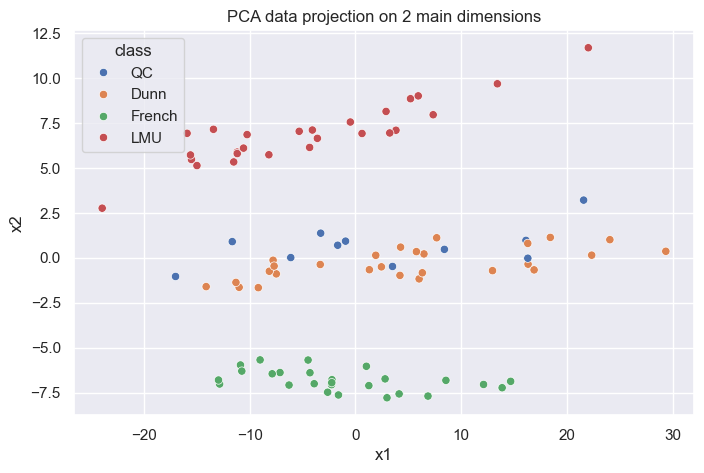

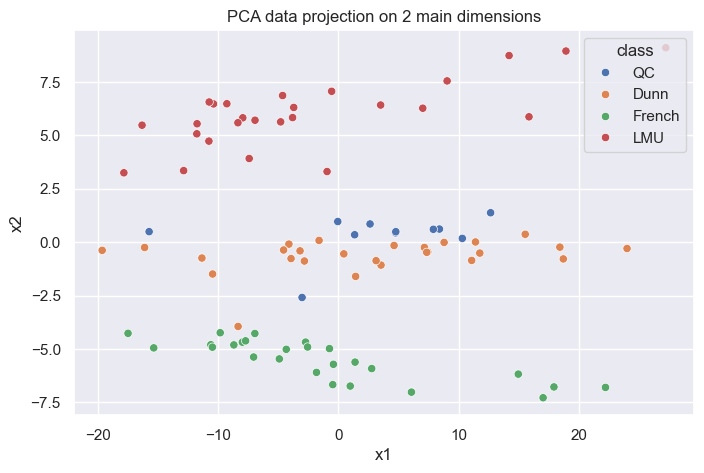

In [4]:
x_tr, x_test, y_tr, y_test, class_map, features = pipeline.run(verbose=False)

# Data classification

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from src.model_training import ModelTrainer, ShapWrapper, plot_feature_importance
import random

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

random.seed(42)
np.random.seed(42)

## Random Forest simple classifier

Best parameters found: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 25}
Model scoring: 1.0


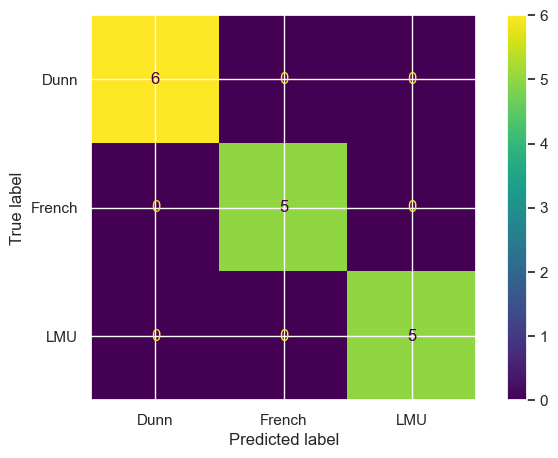

In [6]:
classifier = RandomForestClassifier(random_state=SEED)

param_distrib = dict(
    n_estimators = [5, 10,  15, 20, 25, 30],
    max_depth = [3, 5, 7, 9, 11, 13, 15],
    max_features = ['sqrt', 'log2'],
    bootstrap = [True]
)

# Train model
trainer = ModelTrainer(classifier, param_grid=param_distrib)
trainer.cv = 3
trainer.tune_model(x_tr, y_tr, score='balanced_accuracy')
trainer.train_model(x_tr, y_tr)

# Evaluate model
trainer.evaluate_model(x_test, y_test, metrics=accuracy_score)
y_pred = trainer.best_model.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[v for _, v in class_map.items()])
disp.plot()




# Best features identification

Walk through feature relevance for model classification. Namely, identify which feature contributes the most to the classifier prediction, and give precious insights for biomarker discovery. 

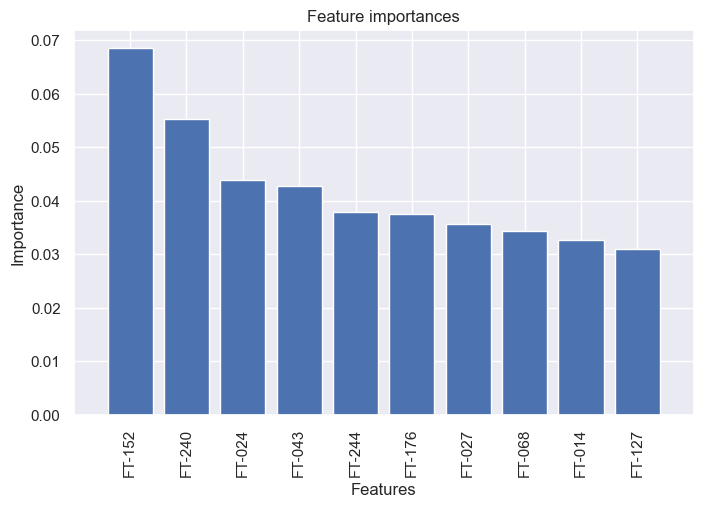

In [7]:
top_feats = plot_feature_importance(trainer.best_model, features)

Ranking features by their gini index, we end up with the following top 10 discriminative features.

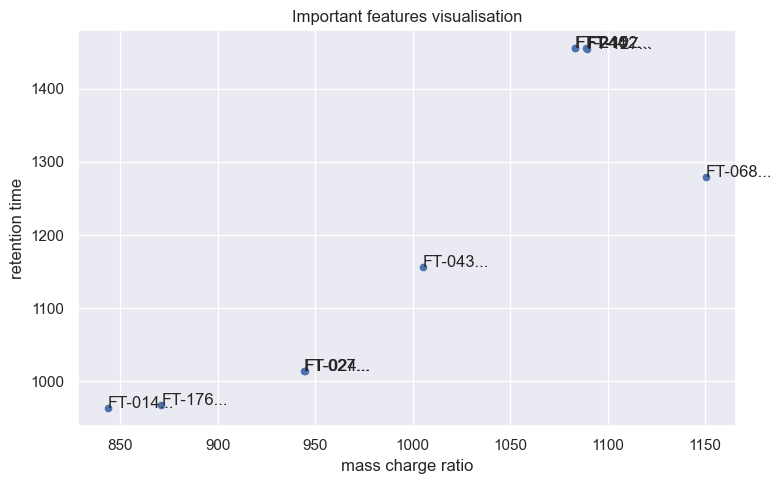

In [8]:
df_feature_meta = pd.read_csv(os.path.join('data/input', 'internship_feature_metadata.csv'))

top_feats_meta = df_feature_meta[df_feature_meta['feature'].isin(top_feats)][['mz', 'rt', 'feature']]
fig = top_feats_meta.plot.scatter(x='mz', y='rt')

for i, point in top_feats_meta.set_index('feature').iterrows():
    fig.text(point[0]+.03, point[1], str(i)[:15] + '...')

plt.xlabel('mass charge ratio')
plt.ylabel('retention time')
plt.title('Important features visualisation')
plt.tight_layout()

Plotting features based on their mass charge ratio and retention time characteristics enable the detection of similar features. Namely, we can identify 7 feature clusters.

## Class specific feature identification

SHAP is a method based on game theory to explain a given ML model individual predictions. 
Roughly, it predicts each feature contribution to the prediction. For instance, we train a model to predict housing prices for a given house based on several features such as the number of rooms. We can compute for this given feature, namely number of rooms, the contribution to the overall housing price prediction.

Here we compute the top features contributions to the classifier predicting either French (_lung cancer_), LMU (_benign disease_) and Dunn (_healthy_). 


In [9]:
import shap

df_tr = pd.DataFrame(x_tr, columns=features) # background
df_te = pd.DataFrame(x_test, columns=features)

shap_explainer = ShapWrapper(trainer.best_model, background=df_tr,\
                              classes = {v : k for k, v in class_map.items()})

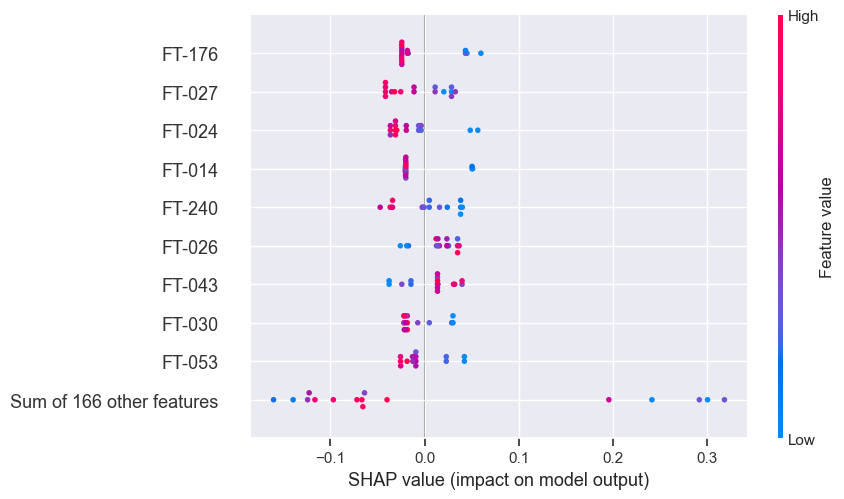

In [13]:
shap_explainer.plot_summary(df_te, cl='French')

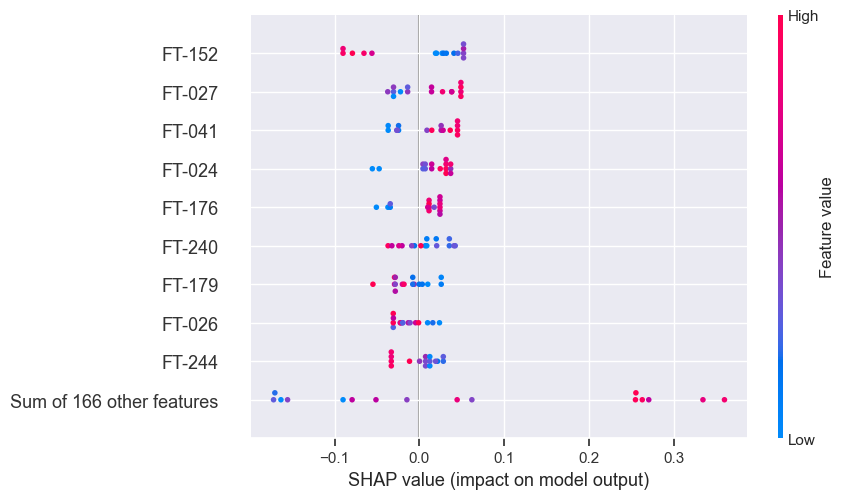

In [14]:
shap_explainer.plot_summary(df_te, cl='Dunn')

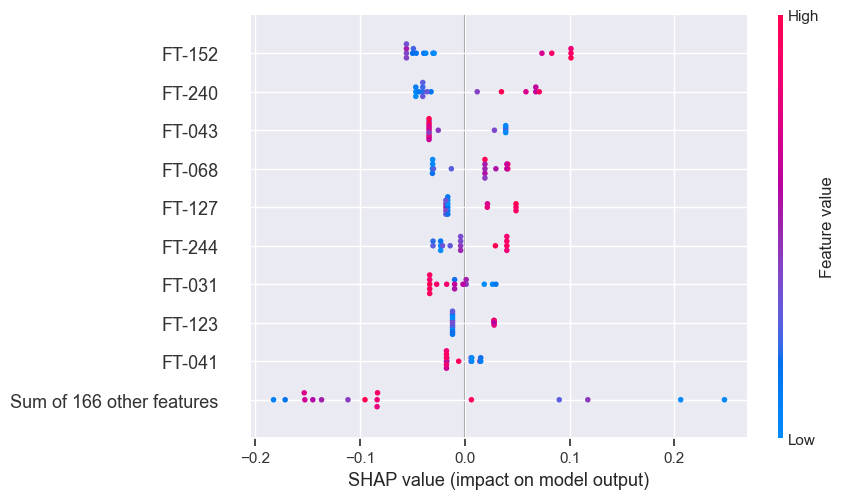

In [15]:
shap_explainer.plot_summary(df_te, cl='LMU')